<a href="https://colab.research.google.com/github/rahiakela/hands-on-unsupervised-learning-using-python/blob/main/2-end-to-end-machine-learning-project/1_data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Preparation

Before we begin exploring unsupervised learning algorithms in detail, we will
review how to set up and manage machine learning projects, covering everything
from acquiring data to building and evaluating a model and implementing a
solution. We will work with supervised learning models—an area most readers should have some experience in—before jumping into unsupervised learning models.

## Setup

In [1]:
'''Main'''
import numpy as np
import pandas as pd
import os

'''Data Viz'''
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

'''Data Prep'''
from sklearn import preprocessing as pp 
from scipy.stats import pearsonr 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss 
from sklearn.metrics import precision_recall_curve, average_precision_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report 

'''Algos'''
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# import xgboost as xgb
import lightgbm as lgb

Let's download creditcardfraud dataset from [Kaggle](https://www.kaggle.com/isaikumar/creditcardfraud).

In [ ]:
from google.colab import files
files.upload() # upload kaggle.json file

In [3]:
%%shell

mkdir -p ~/.kaggle
mv kaggle.json ~/.kaggle/
ls ~/.kaggle
chmod 600 /root/.kaggle/kaggle.json

# download word embeddings from kaggle
kaggle datasets download -d isaikumar/creditcardfraud
unzip -qq creditcardfraud.zip
rm -rf creditcardfraud.zip

kaggle.json
 99% 65.0M/65.9M [00:01<00:00, 33.9MB/s]
100% 65.9M/65.9M [00:01<00:00, 54.2MB/s]


## Loading dataset

We will use a real dataset of anonymized credit card transactions
made by [European cardholders from September 2013](https://www.kaggle.com/isaikumar/creditcardfraud). These transactions are labeled as fraudulent or genuine, and we will build a fraud detection solution using machine learning to predict the correct labels for never-before-seen instances.

This dataset is highly imbalanced. Of the 284,807 transactions, only 492 are
fraudulent (0.172%). This low percentage of fraud is pretty typical for credit
card transactions.

There are 28 features, all of which are numerical, and there are no categorical
variables. These features are not the original features but rather the output of
principal component analysis. The original features were distilled to 28 principal components using this form of dimensionality reduction.

## Data Acquisition

The first step in any machine learning project is data acquisition.

In [4]:
# Read the data
data = pd.read_csv("creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data Exploration

We will generate summary statistics for the data, identify any missing values or categorical features, and count the number of distinct values by feature.

In [5]:
# Generate summary statistics
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [7]:
data["Class"].sum()

492

The total number of positive labels, or fraudulent transactions, is 492. There are 284,807 instances and 31 columns as expected—28 numerical features (V1
through V28), Time, Amount, and Class.

The timestamps range from 0 to 172,792, the amounts range from 0 to
25,691.16, and there are 492 fraudulent transactions. These fraudulent
transactions are also referred to as positive cases or positive labels (labeled as one); the normal transactions are negative cases or negative labels (labeled as zero).

The 28 numerical features are not standardized yet, but we will standardize the
data soon. Standardization rescales the data to have a mean of zero and standard
deviation of one.

>Some machine learning solutions are very sensitive to the scale of the data, so having all the data on the same relative scale—via standardization—is a good machine learning practice.

>Another common method to scale data is normalization, which rescales the data to a zero to one range. Unlike the standardized data, all the normalized data is on a positive scale.

**Identify nonnumerical values by feature**

Some machine learning algorithms cannot handle nonnumerical values or missing values. Therefore, it is best practice to identify nonnumerical values
(also known as not a number, or NaNs).

In the case of missing values, we can impute the value—for example, by
replacing the missing points with the mean, median, or mode of the feature—or
substitute with some user-defined value. In the case of categorical values, we can encode the data such that all the categorical values are represented with a sparse matrix. This sparse matrix is then combined with the numerical features. The machine learning algorithm trains on this combined feature set.



In [8]:
nan_counter = np.isnan(data).sum()
nan_counter

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

**Identify distinct values by feature**

To develop a better understanding of the credit card transactions dataset, let’s
count the number of distinct values by feature.

We have 124,592 distinct timestamps. But we know from earlier that we have 284,807 observations in total. That means that there are multiple transactions at some timestamps.

And, as expected, there are just two classes—one for fraud, zero for not fraud:

In [9]:
distinct_counter = data.apply(lambda x: len(x.unique()))
distinct_counter

Time      124592
V1        275663
V2        275663
V3        275663
V4        275663
V5        275663
V6        275663
V7        275663
V8        275663
V9        275663
V10       275663
V11       275663
V12       275663
V13       275663
V14       275663
V15       275663
V16       275663
V17       275663
V18       275663
V19       275663
V20       275663
V21       275663
V22       275663
V23       275663
V24       275663
V25       275663
V26       275663
V27       275663
V28       275663
Amount     32767
Class          2
dtype: int64

## Generate Feature Matrix and Labels Array

Let’s create and standardize the feature matrix X and isolate the labels array y
(one for fraud, zero for not fraud). 

Later on we will feed these into the machine learning algorithms during training.

In [10]:
# Create the feature matrix X and the labels array Y
data_x = data.copy().drop(["Class"], axis=1)
data_y = data["Class"].copy()

In [11]:
data_x.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


Let’s rescale the feature matrix so that each feature, except for time, has a mean of zero and standard deviation of one.

In [13]:
# Standardize the feature matrix X
features_to_scale = data_x.drop(["Time"], axis=1).columns
sx = pp.StandardScaler(copy=True)
data_x.loc[:, features_to_scale] = sx.fit_transform(data_x[features_to_scale])

In [14]:
data_x.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05
mean,94813.859575,-8.157366e-16,3.154853e-17,-4.409878e-15,-6.734811e-16,-2.874435e-16,4.168992e-16,-8.767997e-16,-2.423604e-16,3.078727e-16,2.026926e-17,1.622758e-15,2.052953e-15,-8.310622e-17,-8.845502e-16,-1.789241e-15,-1.542079e-16,8.046919e-16,-2.547965e-16,-4.550555e-16,2.754870e-16,1.685077e-17,1.478472e-15,-6.797197e-16,1.234659e-16,-7.659279e-16,3.247603e-16,-2.953495e-18,5.401572e-17,3.202236e-16
std,47488.145955,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,0.000000,-2.879855e+01,-4.403529e+01,-3.187173e+01,-4.013919e+00,-8.240810e+01,-1.963606e+01,-3.520940e+01,-6.130252e+01,-1.222802e+01,-2.258191e+01,-4.700128e+00,-1.869868e+01,-5.819392e+00,-2.004428e+01,-4.915191e+00,-1.612534e+01,-2.962645e+01,-1.133266e+01,-8.861402e+00,-7.069146e+01,-4.741907e+01,-1.506565e+01,-7.175446e+01,-4.683638e+00,-1.975033e+01,-5.401098e+00,-5.590660e+01,-4.674612e+01,-3.532294e-01
25%,54201.500000,-4.698918e-01,-3.624707e-01,-5.872142e-01,-5.993788e-01,-5.010686e-01,-5.766822e-01,-4.478860e-01,-1.746805e-01,-5.853631e-01,-4.917360e-01,-7.470224e-01,-4.058964e-01,-6.516198e-01,-4.439565e-01,-6.368132e-01,-5.341353e-01,-5.695609e-01,-5.951621e-01,-5.605369e-01,-2.746334e-01,-3.109433e-01,-7.473476e-01,-2.591784e-01,-5.854676e-01,-6.084001e-01,-6.780717e-01,-1.755053e-01,-1.604440e-01,-3.308401e-01
50%,84692.000000,9.245351e-03,3.965683e-02,1.186124e-01,-1.401724e-02,-3.936682e-02,-2.058046e-01,3.241723e-02,1.871982e-02,-4.681169e-02,-8.533551e-02,-3.209268e-02,1.401448e-01,-1.363250e-02,5.278702e-02,5.251917e-02,7.579255e-02,-7.732604e-02,-4.338370e-03,4.588014e-03,-8.104705e-02,-4.009429e-02,9.345377e-03,-1.792420e-02,6.765678e-02,3.183240e-02,-1.081217e-01,3.325174e-03,3.406368e-02,-2.652715e-01
75%,139320.500000,6.716939e-01,4.867202e-01,6.774569e-01,5.250082e-01,4.433465e-01,2.991625e-01,4.611107e-01,2.740785e-01,5.435305e-01,4.168842e-01,7.245863e-01,6.187332e-01,6.656518e-01,5.144513e-01,7.088502e-01,5.971989e-01,4.705737e-01,5.974968e-01,5.637928e-01,1.725733e-01,2.537392e-01,7.283360e-01,2.364319e-01,7.257153e-01,6.728006e-01,4.996663e-01,2.255648e-01,2.371526e-01,-4.471707e-02
max,172792.000000,1.253351e+00,1.335775e+01,6.187993e+00,1.191874e+01,2.521413e+01,5.502015e+01,9.747824e+01,1.675153e+01,1.419494e+01,2.180758e+01,1.177504e+01,7.854679e+00,7.160735e+00,1.098147e+01,9.699117e+00,1.976044e+01,1.089502e+01,6.014342e+00,6.869414e+00,5.113464e+01,3.703471e+01,1.447304e+01,3.607668e+01,7.569684e+00,1.442532e+01,7.293975e+00,7.831940e+01,1.025434e+02,1.023622e+02


##Feature Engineering and Feature Selection

In most machine learning projects, we should consider feature engineering and
feature selection as part of the solution. Feature engineering involves creating
new features—for example, calculating ratios or counts or sums from the
original features—to help the machine learning algorithm extract a stronger
signal from the dataset.

Feature selection involves selecting a subset of the features for training,
effectively removing some of the less relevant features from consideration. This
may help prevent the machine learning algorithm from overfitting to the noise in
the dataset.

Feature selection is not necessary either since the number of observations
(284,807) vastly outnumbers the number of features (30), which dramatically
reduces the chances of overfitting.



In [25]:
# Check correlation of features
correlation_matrix = pd.DataFrame(data=[], index=data_x.columns, columns=data_x.columns)

for i in data_x.columns:
  for j in data_x.columns:
    correlation_matrix.loc[i, j] = np.round(pearsonr(data_x.loc[:, i], data_x.loc[:, j])[0], 2)

In [30]:
correlation_matrix.style.background_gradient(cmap='coolwarm').set_precision(1)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Time,1.0,0.1,-0.0,-0.4,-0.1,0.2,-0.1,0.1,-0.0,-0.0,0.0,-0.2,0.1,-0.1,-0.1,-0.2,0.0,-0.1,0.1,0.0,-0.1,0.0,0.1,0.1,-0.0,-0.2,-0.0,-0.0,-0.0,-0.0
V1,0.1,1.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.2
V2,-0.0,-0.0,1.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.5
V3,-0.4,-0.0,0.0,1.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.2
V4,-0.1,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.1
V5,0.2,0.0,0.0,-0.0,-0.0,1.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.4
V6,-0.1,0.0,0.0,0.0,-0.0,0.0,1.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.2
V7,0.1,0.0,-0.0,0.0,-0.0,-0.0,0.0,1.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.4
V8,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,1.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.1
V9,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,1.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0


In [33]:
correlation_matrix.to_csv("correlationMatrix.csv")

##Data Visualization

As a final step, let’s visualize the data to appreciate just how imbalanced the
dataset is.Since there are so few cases of fraud to learn from, this is
a difficult problem to solve; fortunately, we have labels for the entire dataset.

Text(0, 0.5, 'Frequency Percentage')

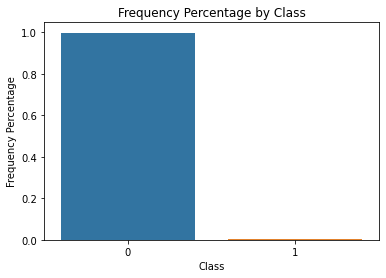

In [34]:
count_classes = pd.value_counts(data['Class'],sort=True).sort_index()
ax = sns.barplot(x=count_classes.index, y=[tuple(count_classes/len(data))[0],tuple(count_classes/len(data))[1]])
ax.set_title('Frequency Percentage by Class')
ax.set_xlabel('Class')
ax.set_ylabel('Frequency Percentage')